# Project 3: RNNs for Sentiment Analysis


------------------------------------------------------
**Olga Bonachera del Pozo** - 100472782

**Daniel Kwapien** - 100472421

**Alejandro Sánchez** - 100472892

------------------------------------------------------

In this notebook we will deploy RNNs to perform sentiment analysis in a real dataset of finantial news. The required preprocesing using standard NLP libraries will be given to you (you have a course on NLP in the second term to learn this part) and your goal will be to define the RNN model, train it and validate the results.


We will use the [Finantial Phrase Bank](https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip), which contains  near 5000 sentences from finantial news:


>*This release of the financial phrase bank covers a collection of 4840 sentences. The selected collection of phrases was annotated by 16 people with adequate background knowledge on financial markets. Three of the annotators were researchers and the remaining 13 annotators were master’s students at Aalto University School of Business with majors primarily in finance, accounting, and economics.*
>
>*The objective of the phrase level annotation task was to classify each example sentence into a positive, negative or neutral category by considering only the information explicitly available in the given sentence. Since the study is focused only on financial and economic domains, the annotators were asked to consider the sentences from the view point of an investor only; i.e. whether the news may have positive, negative or neutral influence on the stock price. As a result, sentences which have a sentiment that is not relevant from an economic or financial perspective are considered neutral.*

Lets load the database and preprocess it using [SpaCy](https://spacy.io/). This part is all given to you, so no need to worry much.




**1. Compute Mean Words Embedding**

In [1]:
# To use it in colab, update spacy
!pip install --upgrade spacy

In [2]:
# Download language model

!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import numpy as np
import pandas as pd
import spacy


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [4]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In lines, we have a list of sentences and an associted label, separated by the character `@`

In [6]:
print(lines[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral



We split the sentence and we code with 0 neutral labels, with 1 negative labels, and with 2 positive labels

In [7]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]

def code_opinion(l):

    d = 0

    if (l=='negative\n'):

        d = 1

    elif (l=='positive\n'):

        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])


In [8]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


Lets plot the histogram of the labels ...

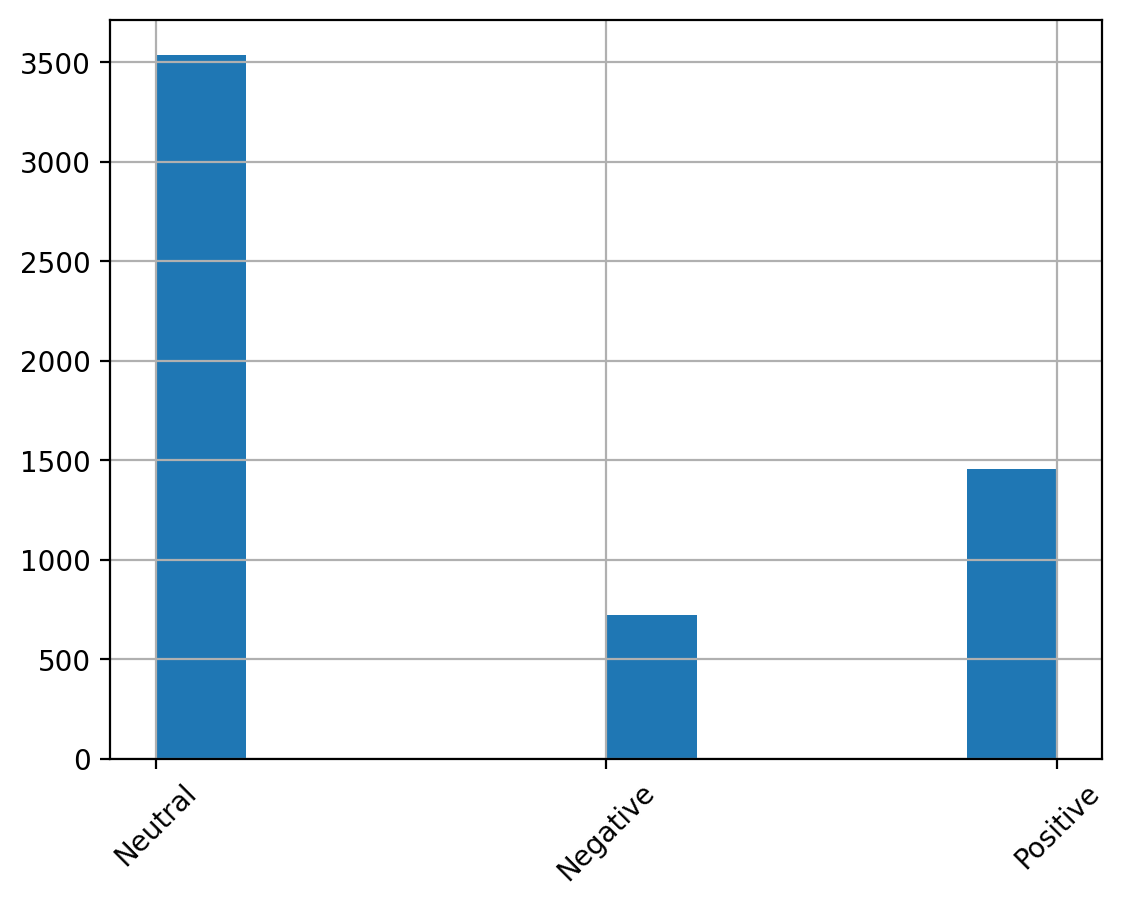

In [9]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()


To simplify the problem, we're fusing together *Neutral* and *Positive* labels. So label 1 is *Negative review* and label 0 is *Positive+Neutral*. Also, we separate between train, validation and test.

In [10]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

### Text pre-processing

With the following code, we pre-process using Spacy each sentence by removing words that are punctuation marks. We also remove [stopping words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html) (words that are not very informative). As a result, we have the list `norm_docs`.

In [11]:
nlp = spacy.load("en_core_web_md") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]



Every item of `norm_docs` corresponds to each of the sentences in the dataset. Each item is itself a list of spacy tokens (basically words with different attributes). The most important attribute for us the the *word embedding vector*. For instance, lets print the first sentence

In [12]:
print(f'The first original sentence is: {phrases[0]}\n')

print(f'The first normalized sentence is: {norm_docs[0]}. The length of the document is {len(norm_docs[0])} tokens')

The first original sentence is: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

The first normalized sentence is: [According, Gran, company, plans, production, Russia, company, growing]. The length of the document is 8 tokens


We can access to the word embedding of each token using the attribute `.vector`:

In [13]:
print(f'The word embedding associated with the token {norm_docs[0][0].text} is\n')
print(norm_docs[0][0].vector)

The word embedding associated with the token According is

[-7.2518e-01 -6.5831e+00  1.9781e+00  1.5750e+00  3.7848e+00 -7.7536e-01
  1.6243e+00  1.3813e+00 -7.4554e-01 -3.3811e+00  5.6047e-01  1.1629e+00
 -9.7465e-01  6.6956e-01  4.2558e-01  4.1766e+00  4.6478e+00  3.5616e+00
  7.3597e-01  3.6554e-01 -2.2610e+00 -4.1928e+00 -6.7455e-01  1.7693e+00
 -1.5665e-01 -1.1390e+00  1.8747e+00  2.9538e+00  5.5879e-01  3.0424e-01
  2.3027e-01  3.6405e-02  8.8395e-01  1.0494e+00 -1.7269e+00 -3.3406e-01
 -1.0464e+00 -9.8123e-01 -2.1267e+00 -2.9542e+00 -4.3075e+00 -1.5900e+00
 -8.9226e-01  3.6363e-01 -3.7703e+00 -1.8992e+00 -5.3433e-01  4.0256e+00
 -1.8628e+00 -1.9761e+00  1.2977e+00  3.6029e+00  1.6310e+00 -2.5195e+00
  2.0482e+00 -1.4805e+00 -1.4294e-01 -2.7591e+00 -3.4827e-01 -6.1484e+00
 -5.9045e-01 -5.3691e-01 -7.3631e-01  3.1585e+00  5.7914e+00 -1.1208e+00
 -2.5045e+00 -2.2957e+00  2.7173e+00  1.1104e+00  2.0943e+00 -2.6719e+00
 -2.6322e+00 -3.9377e+00 -1.3198e+00  3.5639e+00 -1.3974e+00  2.7

You can check that the word embedding dimension is 300 ...

In [14]:
print(f'The WE dimension is {norm_docs[0][0].vector.shape}')

The WE dimension is (300,)


### Length normalization

Note that in this problem we're working with sequences of text of different length. This is in principle not a problem for RNNs. However, there's one additional pre-processing step that we have to do. When we feed the RNN function **all sequences in the mini-batch must have the same length**. Then we will use the corresponding state to make the prediction.

For simplicity, we are taking here a non-efficient solution. Instead of normalize lengths at a batch level, we are normalizing the whole dataset so all sequences have the same length. To do so, we're adding **junk tokens** to all sentences so they artificially are of the same length. However, we will keep in a list the real length of each data, since the sentiment analysis prediction will be made using the RNN state corresponding to the **last real token**.



In [15]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [16]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

Recall that for each document, the sequence of word embeddings is obtained using the `.vector` attribute per token ...

### RNN classification

Our goal is to implement an LSTM that takes as input the sequence of word embeddings and predicts the binary label. In the list `lengths` we have the length per document (before adding the junk tokens). The LSTM prediction **must be done using the LSTM state after processing the last real token**. That means we ignore the LSTM states after we start processing the junk tokens.


A few comments:

- The LSTM is trained using mini-batches. So the input is a tensor of dimension (batch_size, seq_length, max_l). You have to generate this tensor using the lists implemented before (`docs_train`, `docs_val`, `docs_test`).
- You don't care about the LSTM initializaiton. Use the default one.
- The LSTM provides the list of states upon processing the sequences of max_l word embeddings. For each sentence, you have to predict the label using the appropiate state (the one after processing the last real word). My advise is that you store in a list the decision states for each data in the minibatch and then concatenate them in a tensor using `torch.stack`.
- We will use a single MLP layer to perform the prediction. Between the LSTM and the MLP, we include a dropout layer.
- The network will take some time to train, so my advise is to save the network parameters after each epoch (in a separate file), so early stopping can be implemented without re-training.
- Validate the dimension of the LSTM state.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/RNN.png' width=800 />




In [17]:
from torch import nn
from torch import optim
import torch

>**Exercise:** Complete the following code to construct the RNN classifier

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,prob=0.5):


        super().__init__()

        self.hidden_dim = hidden_dim

        self.input_size = input_size

        # LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=prob, batch_first=True)

        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Drop layer
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):

        '''

        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify

        '''

        batch_size = x.size(0)
        seq_length = x.size(1)

        # Compute the RNN output (sequence of states for the whole input)
        r_out, _ =  self.rnn(x, h0)

        # Now it comes the tricky part. You have to stack in a (batch_size, hidden_dim) tensor, the right state
        # for each sequece. Namely, the state after processing the last real token (not the junk # ones)
        # The function torch.stack() can be handy

        # This function selects the last context state of the sequence depending on its size
        aux = torch.stack([r_out[[d],lengths[d]-1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim])
        # We classify using such tensor (don't forget the dropout!)

        output = self.logsoftmax(self.fc1(self.dropout(aux)))


        return output

Let's first illustrate how we can get the output of the (untrained) RNN network given our texts. For example, let's get the RNN output for the first three training texts. The first step is to get the **sequences of word embeddings** of each of them...

In [19]:
idx = [1,2,3]

#[w.vector for w in docs_train[d]] generates the list of word vectors for the d-th document
x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx])

<ipython-input-19-31b6a0fc2f9f>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx])


In [20]:
d=1

np.array([docs_train[d][w].vector for w in range(len_train[d])]).shape

(14, 300)

In [21]:
docs_train[1]

[company,
 reported,
 net,
 sales,
 302,
 mln,
 euro,
 $,
 mln,
 operating,
 margin,
 16,
 pct,
 2006,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #,
 #]

In [22]:
aux = torch.Tensor([np.mean([docs_train[d][w].vector for w in range(len_train[d])],0) for d in idx])

The shape of `x_input` should be (3,max_l,300)

In [23]:
x_input.shape

torch.Size([3, 35, 300])

Let's instantiate the RNN class

In [24]:
my_RNN = RNN(300,2,20,1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


> **Exercise:** evaluate the RNN otuput for `x_input` and check that the ouput dimensions make sense

In [25]:
o = my_RNN.forward(x_input,[lengths[d] for d in idx])

In [26]:
print(o)

tensor([[-1.0276, -0.4430],
        [-0.7514, -0.6381],
        [-0.4769, -0.9694]], grad_fn=<LogSoftmaxBackward0>)


In [27]:
o.shape

torch.Size([3, 2])

> **Exercise:** Complete the following class, which inherits the previous one and it adds a training loop, an evaluation method, and functionalities to save the model every few epochs

In [28]:
class RNN_with_train(RNN):

    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis'):

        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)

        self.lr = lr # Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.batch_size = batch_size

        self.saved_files = saved_files


    def predict_proba(self,docs,lengths,Y=None):

        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.

        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0

        with torch.no_grad():

            x_input = torch.Tensor([[w.vector for w in d] for d in docs])

            logprobs = self.forward(x_input,[len(d) for d in docs]).detach().numpy()

            if(len(Y)>0):
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]

        return logprobs,accuracy


    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):

        '''
        Método de entrenamiento.

        - docs_train, docs_val: training/validation documents  (each is a list of spacy tokens).
          Normalized in length!
        - len_train/len_val: real lengths
        '''

        self.print_every = print_every

        self.epochs=epochs

        # Optimization Loop

        self.num_train = len(docs_train) # Number of training points

        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches

        self.num_val = len(docs_val) # Number of validation points

        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validation batches

        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels

        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels


        for e in range(int(self.epochs)):

            self.train() # Activate dropout

            # Random data permutation

            idx = np.random.permutation(self.num_train)

            running_loss = 0.

            for i in range(int(self.num_batchs)):

                self.optim.zero_grad()

                # Indices of the data entering the batch

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d]>0]

                # We code each document using the sequences of word embeddings

                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # We compute the classifier output for every data

                out = self.forward(x_input,[len_train[d] for d in idx_batch])

                # Cost function and gradient descent step

                loss = self.criterion(out,labels[idx_batch])

                running_loss += loss.item()

                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # SGD steps

                self.optim.step()

            self.loss_during_training.append(running_loss/self.num_batchs)

            # We save model parameters

            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

            # We repeat for validation

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                idx = np.random.permutation(self.num_val)

                running_loss = 0.

                for i in range(int(self.num_batchs_val)):

                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]

                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out = self.forward(x_input,[len_val[d] for d in idx_batch])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)



            if(e % self.print_every == 0):

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

> **Exercise:** Instantiate and train the class using a hidden state of 20 dimensions and dropout probability equal to 0.3. Train for 40 epochs (can take a while)

In [29]:
my_RNN = RNN_with_train(input_size=300,output_size=2,hidden_dim=20,n_layers=1, prob=0.3)

#Call train

my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training loss after 0 epochs: 0.536997479526964. Validation loss: 0.4044012592898475
Training loss after 1 epochs: 0.3849048555305559. Validation loss: 0.3382168776459164
Training loss after 2 epochs: 0.33781973119467906. Validation loss: 0.30593391756216687
Training loss after 3 epochs: 0.3186582649407321. Validation loss: 0.2931057463089625
Training loss after 4 epochs: 0.28913849796334357. Validation loss: 0.2833673068218761
Training loss after 5 epochs: 0.2753844585728972. Validation loss: 0.2750039142039087
Training loss after 6 epochs: 0.2660884516288156. Validation loss: 0.2613625294632382
Training loss after 7 epochs: 0.24571483204626057. Validation loss: 0.2592462334367964
Training loss after 8 epochs: 0.23297162588736783. Validation loss: 0.244612578716543
Training loss after 9 epochs: 0.2180154342969803. Validation loss: 0.2411410767171118
Training loss after 10 epochs: 0.21105839914246782. Validation loss: 0.23040840526421866
Training loss after 11 epochs: 0.196791634167710

> **Exercise:** Plot both validation and training loss. Recover the model parameters for the epoch that minimized the validation loss. To do so, note that at every epoch the model parameters are save in a certain file named  `RNN_sentiment_analysis_epoch_X.pth` (unless you changed the default value), where `X` is the epoch. The function to re-state the parameters of the network are  `state_dict = my_RNN.load_state_dict(torch.load('RNN_sentiment_analysis_epoch_X.pth'))
`

Text(0.5, 1.0, 'Training for LSTM without Attention')

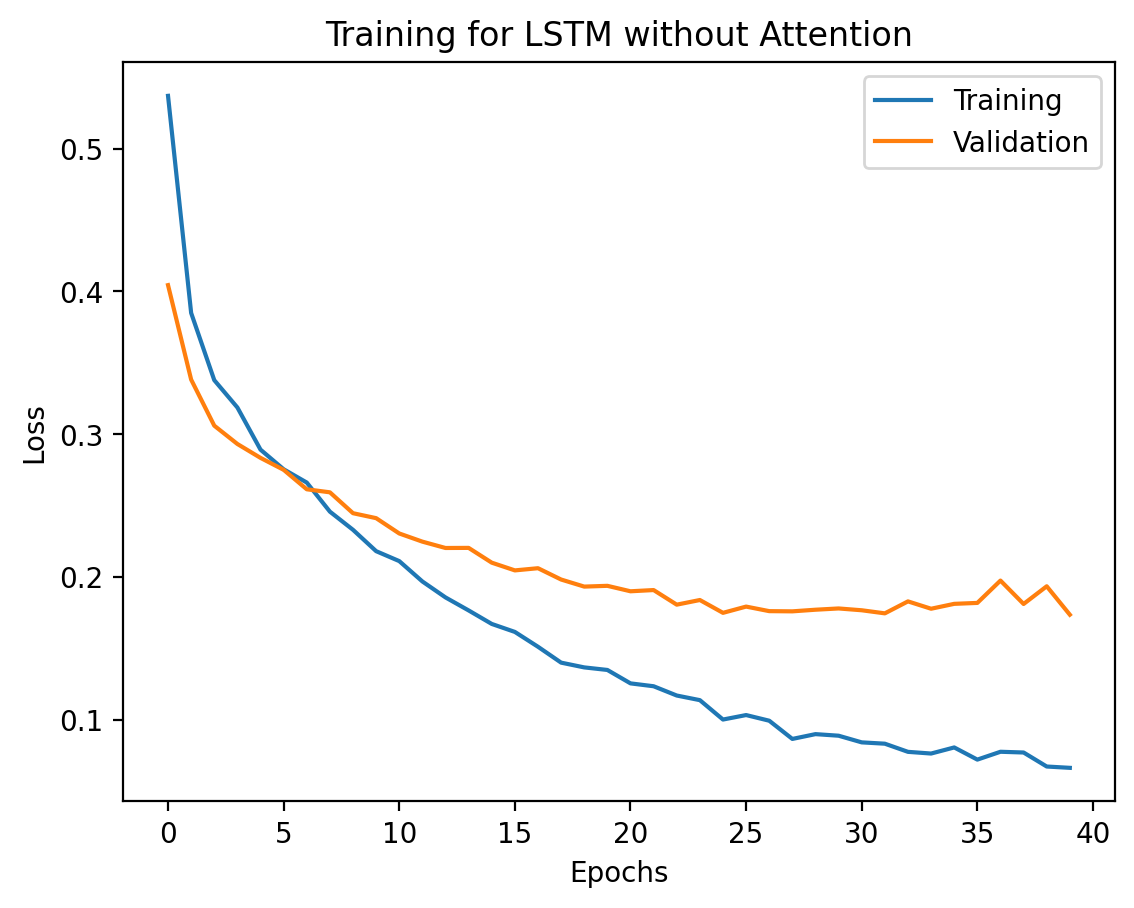

In [30]:
# Plotting the train/val loss
plt.figure()
plt.plot(my_RNN.loss_during_training, label='Training')
plt.plot(my_RNN.valid_loss_during_training, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training for LSTM without Attention')

In [31]:
# Recovering the best validation parameters

idx_min = np.argsort(my_RNN.valid_loss_during_training)
my_RNN.load_state_dict(torch.load(my_RNN.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

<All keys matched successfully>

> **Exercise:** Using the method `predict_proba`, compute the accuracy and class probabilities for the data in the test set. Note that the method returns log-probabilities that you have to exponentiate.

In [33]:
logprobs,acc = my_RNN.predict_proba(docs_test, len_test, y_test)

probs = np.exp(logprobs)

print(f"The test accuracy is {acc}")

The test accuracy is 0.8872377622377622


The following code plots the ROC curve of the classifiers, and it computes the area under the curve:

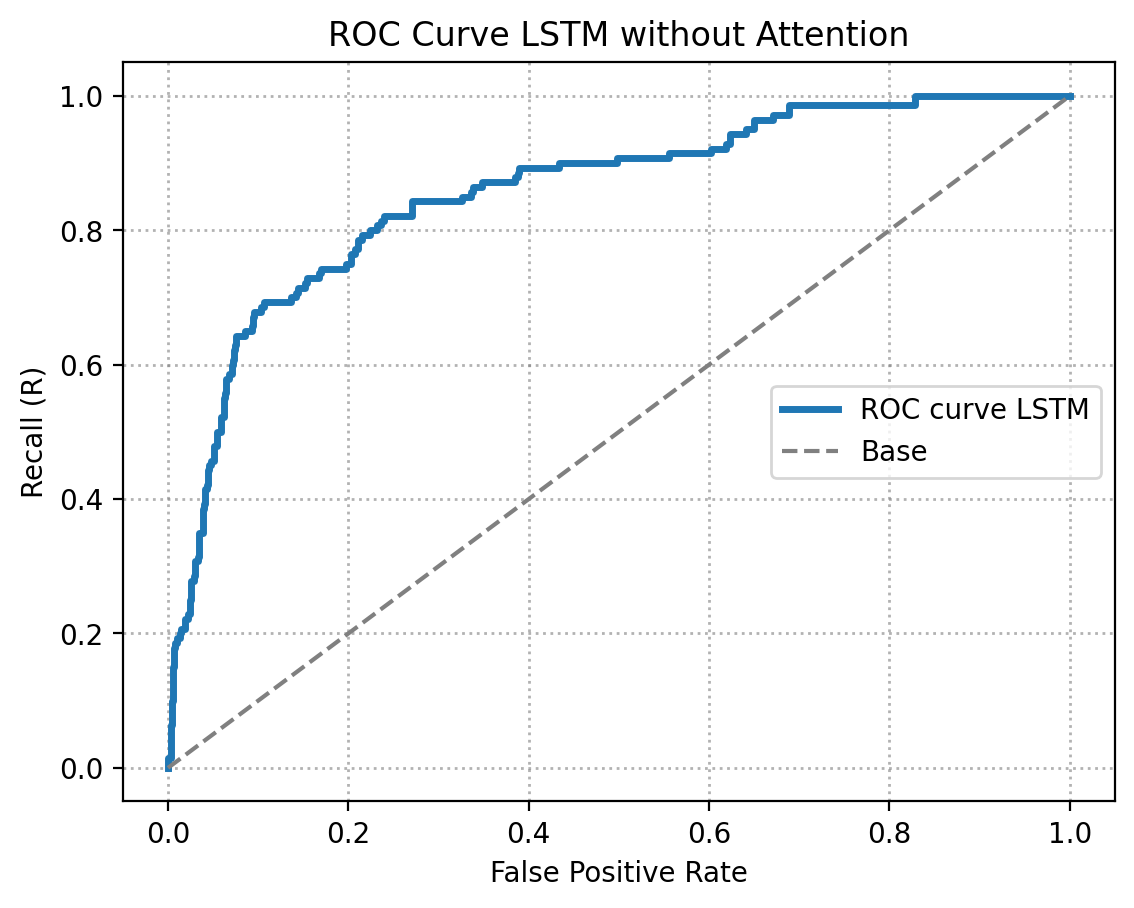

AUC ROC for LSTM is 0.8570076835515082


In [34]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.5, label='Base')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('ROC Curve LSTM without Attention')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")